In [1]:
# Verify kernel is using the correct environment
import sys
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")
print(f"Using UV environment: {'/root/.venv' in sys.executable}")

Python executable: /root/.venv/bin/python
Python version: 3.11.14 (main, Oct 14 2025, 21:26:53) [Clang 20.1.4 ]
Using UV environment: True


In [2]:
# Import required libraries
from __future__ import annotations

import os
import random
from collections import Counter
from pathlib import Path
import sys
from typing import List

# Force CPU to avoid GPU memory issues with large graphs
# os.environ.setdefault('JAX_PLATFORMS', 'cpu')

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Add tools directory to path
sys.path.insert(0, str(Path.cwd() / 'tools'))

from tv_graph import TVGraph
from thrml import Block, BlockGibbsSpec, FactorSamplingProgram, SamplingSchedule, sample_states
from thrml.block_management import block_state_to_global
from thrml.block_sampling import sample_blocks
from thrml.models import CategoricalEBMFactor, CategoricalGibbsConditional
from thrml.models.ebm import DEFAULT_NODE_SHAPE_DTYPES
from thrml.pgm import CategoricalNode

## Check Device Usage

## Configuration

In [ ]:
# Configuration parameters
INPUT_FOLDER = Path("input/fcc-seed87-st50-ch30-post-auction-50st-15ch")
LAMBDA_CONFLICT = 8.0
LAMBDA_DOMAIN = 100.0
WARMUP_STEPS = 200
NUM_SAMPLES = 200
STEPS_PER_SAMPLE = 1
SEED = 0

# Blocking strategy parameters
BLOCK_SIZE_GEOGRAPHIC = 3  # Stations per geographic block
BLOCK_SIZE_RANDOM = 3      # Stations per random block
BLOCK_SIZE_INTERFERENCE = 3  # Max stations per interference block

## Load Graph Data

In [4]:
graph = TVGraph(INPUT_FOLDER)
print(f"Loaded graph with {graph.station_count:,} stations and {graph.channel_count:,} channels.")

Loaded graph with 50 stations and 15 channels.


## Helper Functions

In [23]:
def make_domain_factor(graph: TVGraph, nodes: list[CategoricalNode], penalty: float) -> CategoricalEBMFactor:
    station_count = len(nodes)
    channel_count = graph.channel_count
    weights = np.full((station_count, channel_count), -float(penalty), dtype=np.float32)
    for station in graph.stations_by_id.values():
        if station.station_index is None:
            raise ValueError(f"Station {station.station_id} is missing a contiguous index.")
        weights[station.station_index, station.domain_indices] = 0.0
    return CategoricalEBMFactor([Block(nodes)], jnp.asarray(weights))


def make_interference_factor(
    graph: TVGraph, nodes: list[CategoricalNode], penalty: float
) -> CategoricalEBMFactor | None:
    seen: set[tuple[int, int, int, int]] = set()
    constraint_rows: list[tuple[int, int, int, int]] = []
    for station in graph.stations_by_id.values():
        if station.station_index is None:
            continue
        a_idx = station.station_index
        for interference, partner_idx in station.interferences_deduped():
            a_chan_idx = interference.subject_channel_index
            b_chan_idx = interference.other_channel_index
            key = (a_idx, partner_idx, a_chan_idx, b_chan_idx)
            if key in seen:
                raise ValueError(f"Duplicate constraint: {key}")
            seen.add(key)
            constraint_rows.append(key)

    if not constraint_rows:
        return None

    channel_count = graph.channel_count
    edge_count = len(constraint_rows)
    weights = np.zeros((edge_count, channel_count, channel_count), dtype=np.float32)
    head_nodes: list[CategoricalNode] = []
    tail_nodes: list[CategoricalNode] = []

    for idx, (a_idx, b_idx, a_chan_idx, b_chan_idx) in enumerate(constraint_rows):
        head_nodes.append(nodes[a_idx])
        tail_nodes.append(nodes[b_idx])
        weights[idx, a_chan_idx, b_chan_idx] = -float(penalty)

    return CategoricalEBMFactor([Block(head_nodes), Block(tail_nodes)], jnp.asarray(weights))


def prepare_initial_state(
    graph: TVGraph, free_blocks: list[Block], seed: int
) -> tuple[list[jnp.ndarray], int, int]:
    """Build initial state for blocks (each block may contain multiple nodes)."""
    key = jax.random.PRNGKey(seed)
    init_state: list[jnp.ndarray] = []
    post_count = 0
    random_count = 0
    
    for block in free_blocks:
        block_channels = []
        for node in block.nodes:
            # Find station index for this node
            station_index = None
            for idx, n in enumerate(nodes):
                if n is node:
                    station_index = idx
                    break
            
            if station_index is None:
                raise ValueError("Could not find station index for node")
            
            station_id = graph.station_id_for_index(station_index)
            station = graph.station(station_id)
            new_channel = station.new_channel
            
            if new_channel is not None:
                if new_channel not in graph.channel_values:
                    channel_idx = graph.channel_count - 1
                else:
                    channel_idx = graph.channel_index_for_channel(new_channel)
                post_count += 1
            else:
                domain = np.asarray(station.domain_indices, dtype=np.int32)
                if domain.size == 0:
                    raise ValueError(f"Station {station.station_id} has an empty domain.")
                key, subkey = jax.random.split(key)
                channel_idx = int(jax.random.choice(subkey, domain))
                random_count += 1
            
            block_channels.append(channel_idx)
        
        init_state.append(jnp.asarray(block_channels, dtype=jnp.uint8))
    
    return init_state, post_count, random_count


def block_assignment_to_array(block_state: list[jnp.ndarray], free_blocks: list[Block]) -> np.ndarray:
    """Flatten block state to array in proper station order.
    
    Args:
        block_state: List of block channel assignments
        free_blocks: The block structure (needed to map block positions to station indices)
    
    Returns:
        Array indexed by station_index containing channel assignments
    """
    # Find total number of stations
    station_count = sum(len(block.nodes) for block in free_blocks)
    assignments = np.full(station_count, -1, dtype=np.int32)
    
    for block, block_channels in zip(free_blocks, block_state):
        block_arr = np.asarray(block_channels, dtype=np.int32)
        if block_arr.ndim == 0:
            block_arr = np.array([int(block_arr)])
        
        # Find station index for each node in this block
        for node, channel_idx in zip(block.nodes, block_arr):
            station_index = None
            for idx, n in enumerate(nodes):
                if n is node:
                    station_index = idx
                    break
            if station_index is None:
                raise ValueError("Could not find station index for node")
            assignments[station_index] = int(channel_idx)
    
    if np.any(assignments == -1):
        raise ValueError("Some stations were not assigned channels")
    
    return assignments


def evaluate_energy(program: FactorSamplingProgram, factors: list[CategoricalEBMFactor], block_state: list[jnp.ndarray]) -> float:
    global_state = block_state_to_global(list(block_state), program.gibbs_spec)
    total = 0.0
    for factor in factors:
        total += float(factor.energy(global_state, program.gibbs_spec))
    return total


def score_assignment(graph: TVGraph, assignment: np.ndarray) -> dict[str, object]:
    channel_values = graph.channel_for_channel_id
    domain_mask = graph.domain_mask
    domain_violations = 0
    for station_index, channel_index in enumerate(assignment):
        if not domain_mask[station_index, channel_index]:
            domain_violations += 1

    violations = 0
    violations_by_type: Counter[str] = Counter()
    seen_pairs: set[tuple[int, int, int, int]] = set()

    for station in graph.stations_by_id.values():
        if station.station_index is None:
            continue
        a_idx = station.station_index
        assigned_a_idx = int(assignment[a_idx])
        assigned_a_val = channel_values[assigned_a_idx]

        for interference in station.interferences:
            if assigned_a_val != interference.subject_channel:
                continue
            for partner_idx in interference.station_indices:
                assigned_b_idx = int(assignment[partner_idx])
                assigned_b_val = channel_values[assigned_b_idx]
                if assigned_b_val != interference.other_channel:
                    continue

                if a_idx <= partner_idx:
                    key = (a_idx, partner_idx, assigned_a_idx, assigned_b_idx)
                    constraint_type = interference.constraint_type
                else:
                    key = (partner_idx, a_idx, assigned_b_idx, assigned_a_idx)
                    constraint_type = interference.constraint_type

                if key in seen_pairs:
                    continue
                seen_pairs.add(key)
                violations += 1
                violations_by_type[constraint_type] += 1

    return {
        "domain_violations": domain_violations,
        "violations": violations,
        "violations_by_type": violations_by_type,
    }

## Blocking Strategy Functions

In [24]:
def create_single_node_blocks(nodes: list[CategoricalNode]) -> list[Block]:
    """Strategy 1: One node per block (baseline)."""
    return [Block([node]) for node in nodes]


def create_geographic_blocks(nodes: list[CategoricalNode], block_size: int) -> list[Block]:
    """Strategy 2: Group consecutive stations (assumes stations are ordered geographically)."""
    blocks = []
    for i in range(0, len(nodes), block_size):
        block_nodes = nodes[i:i+block_size]
        if block_nodes:  # Handle remainder
            blocks.append(Block(block_nodes))
    return blocks


def create_random_blocks(nodes: list[CategoricalNode], block_size: int, seed: int) -> list[Block]:
    """Strategy 3: Randomly group stations (shuffle indices, not nodes).
    
    IMPORTANT: We shuffle station INDICES, then group them, maintaining the 
    node[i] -> station_i mapping for correct factor construction.
    """
    station_count = len(nodes)
    indices = list(range(station_count))
    random.seed(seed)
    random.shuffle(indices)
    
    blocks = []
    for i in range(0, len(indices), block_size):
        block_indices = indices[i:i+block_size]
        # Create block with nodes in their ORIGINAL positions (sorted indices)
        block_nodes = [nodes[idx] for idx in sorted(block_indices)]
        if block_nodes:
            blocks.append(Block(block_nodes))
    return blocks


def create_interference_blocks(
    graph: TVGraph, nodes: list[CategoricalNode], max_block_size: int
) -> list[Block]:
    """Strategy 4: Greedy interference-based blocking.
    
    Repeatedly pops an unassigned seed, grows a block by greedily choosing 
    the unassigned neighbor with the most shared interference edges, and 
    falls back to any unassigned node if no neighbors remain.
    """
    station_count = len(nodes)
    unassigned = set(range(station_count))
    blocks = []
    
    # Build interference edge counts for greedy selection
    def count_shared_edges(station_idx: int, block_indices: set[int]) -> int:
        """Count how many interference edges connect station_idx to the current block."""
        station = graph.station(graph.station_id_for_index(station_idx))
        neighbors = station.neighbor_indices()
        return len(neighbors & block_indices)
    
    while unassigned:
        # Pop a seed station (arbitrary choice from unassigned)
        seed = unassigned.pop()
        block_indices = {seed}
        
        # Greedily grow the block
        while len(block_indices) < max_block_size and unassigned:
            # Get all neighbors of current block members
            candidate_neighbors = set()
            for idx in block_indices:
                station = graph.station(graph.station_id_for_index(idx))
                neighbors = station.neighbor_indices()
                candidate_neighbors.update(neighbors & unassigned)
            
            if candidate_neighbors:
                # Greedy: choose neighbor with most shared interference edges
                best_neighbor = max(
                    candidate_neighbors,
                    key=lambda idx: count_shared_edges(idx, block_indices)
                )
                unassigned.remove(best_neighbor)
                block_indices.add(best_neighbor)
            elif unassigned:
                # Fallback: no neighbors remain, pick any unassigned node
                fallback = unassigned.pop()
                block_indices.add(fallback)
            else:
                break
        
        # Create block from indices
        block_nodes = [nodes[idx] for idx in sorted(block_indices)]
        blocks.append(Block(block_nodes))
    
    return blocks

## Sampling Function

In [25]:
def run_sampling(
    graph: TVGraph,
    nodes: list[CategoricalNode],
    free_blocks: list[Block],
    strategy_name: str,
    lambda_conflict: float,
    lambda_domain: float,
    warmup_steps: int,
    num_samples: int,
    seed: int,
) -> tuple[np.ndarray, dict, float, float]:
    """Run sampling with given blocking strategy and return best sample."""
    
    print(f"\n{'='*60}")
    print(f"Strategy: {strategy_name}")
    print(f"Number of blocks: {len(free_blocks)}")
    block_sizes = [len(block.nodes) for block in free_blocks]
    print(f"Block sizes: min={min(block_sizes)}, max={max(block_sizes)}, avg={np.mean(block_sizes):.1f}")
    print(f"{'='*60}")
    
    # Build factors
    domain_factor = make_domain_factor(graph, nodes, penalty=lambda_domain)
    conflict_factor = make_interference_factor(graph, nodes, penalty=lambda_conflict)
    factors = [domain_factor, conflict_factor] if conflict_factor else [domain_factor]
    
    # Build sampling program
    gibbs_spec = BlockGibbsSpec(
        free_super_blocks=free_blocks,
        clamped_blocks=[],
        node_shape_dtypes=DEFAULT_NODE_SHAPE_DTYPES,
    )
    samplers = [CategoricalGibbsConditional(graph.channel_count) for _ in free_blocks]
    program = FactorSamplingProgram(gibbs_spec, samplers, factors, other_interaction_groups=[])
    
    # Initialize
    init_state, post_count, random_count = prepare_initial_state(graph, free_blocks, seed)
    print(f"Initial state: {post_count} post-auction, {random_count} random")
    
    initial_assignment = block_assignment_to_array(init_state, free_blocks)
    init_energy = evaluate_energy(program, factors, init_state)
    init_stats = score_assignment(graph, initial_assignment)
    
    # DEBUG: Check if energy matches formula
    expected_energy = (init_stats['violations'] * lambda_conflict) + (init_stats['domain_violations'] * lambda_domain)
    print(f"Initial: energy={init_energy:.2f}, violations={init_stats['violations']}, "
          f"domain breaches={init_stats['domain_violations']}")
    print(f"  ⚠️  Expected energy from formula: {expected_energy:.2f}")
    if abs(init_energy - expected_energy) > 0.1:
        print(f"  ❌ MISMATCH: difference = {init_energy - expected_energy:.2f}")
        # What violations/breaches would give this energy?
        for v in range(200):
            for d in range(20):
                if abs((v * lambda_conflict + d * lambda_domain) - init_energy) < 0.1:
                    print(f"     Energy {init_energy:.2f} would come from: {v} violations, {d} domain breaches")
                    break
    else:
        print(f"  ✓ Energy matches formula")
    
    # Sample
    key = jax.random.PRNGKey(seed ^ 0xFEED5EED)
    state_free = [jnp.asarray(block) for block in init_state]
    clamp_state = []
    sampler_states = [sampler.init() for sampler in samplers]
    
    samples = []
    sample_states = []  # Store block states for energy evaluation
    
    # Warmup
    for i in range(warmup_steps):
        key, subkey = jax.random.split(key)
        state_free, sampler_states = sample_blocks(subkey, state_free, clamp_state, program, sampler_states)
        if (i + 1) % 50 == 0:
            print(f"  Warmup step {i + 1}/{warmup_steps}")
    
    samples.append(block_assignment_to_array(state_free, free_blocks))
    sample_states.append([jnp.array(s) for s in state_free])
    
    # Sampling
    for i in range(1, num_samples):
        key, subkey = jax.random.split(key)
        state_free, sampler_states = sample_blocks(subkey, state_free, clamp_state, program, sampler_states)
        samples.append(block_assignment_to_array(state_free, free_blocks))
        sample_states.append([jnp.array(s) for s in state_free])
        if (i + 1) % 50 == 0:
            print(f"  Sample {i + 1}/{num_samples}")
    
    samples_array = np.stack(samples, axis=0)
    
    # Find best
    best_index = 0
    best_assignment = samples_array[0]
    best_stats = score_assignment(graph, best_assignment)
    best_energy = evaluate_energy(program, factors, sample_states[0])
    
    for idx in range(1, len(samples_array)):
        assignment = samples_array[idx]
        stats = score_assignment(graph, assignment)
        energy = evaluate_energy(program, factors, sample_states[idx])
        if stats["violations"] < best_stats["violations"] or (
            stats["violations"] == best_stats["violations"] and energy < best_energy
        ):
            best_index = idx
            best_stats = stats
            best_energy = energy
    
    print(f"\nBest sample #{best_index}: energy={best_energy:.2f}, "
          f"violations={best_stats['violations']}, "
          f"domain breaches={best_stats['domain_violations']}")
    
    return best_assignment, best_stats, best_energy, init_energy


## Create Nodes and Run All Strategies

In [26]:
# Create nodes (shared across all strategies)
nodes = [CategoricalNode() for _ in graph.station_ids_by_index]
print(f"Created {len(nodes)} categorical nodes")

Created 50 categorical nodes


### Strategy 1: Single-Node Blocks (Baseline)

In [ ]:
blocks_single = create_single_node_blocks(nodes)

best_single, stats_single, energy_single, init_energy_single = run_sampling(
    graph=graph,
    nodes=nodes,
    free_blocks=blocks_single,
    strategy_name="Single-Node Blocks",
    lambda_conflict=LAMBDA_CONFLICT,
    lambda_domain=LAMBDA_DOMAIN,
    warmup_steps=WARMUP_STEPS,
    num_samples=NUM_SAMPLES,
    seed=SEED,
)


Strategy: Single-Node Blocks
Number of blocks: 50
Block sizes: min=1, max=1, avg=1.0
Initial state: 50 post-auction, 0 random
Initial: energy=1296.00, violations=162, domain breaches=0
  ⚠️  Expected energy from formula: 1296.00
  ✓ Energy matches formula
Initial state: 50 post-auction, 0 random
Initial: energy=1296.00, violations=162, domain breaches=0
  ⚠️  Expected energy from formula: 1296.00
  ✓ Energy matches formula


### Strategy 2: Geographic Blocks

In [28]:
blocks_geographic = create_geographic_blocks(nodes, BLOCK_SIZE_GEOGRAPHIC)

best_geo, stats_geo, energy_geo, init_energy_geo = run_sampling(
    graph=graph,
    nodes=nodes,
    free_blocks=blocks_geographic,
    strategy_name=f"Geographic Blocks (size={BLOCK_SIZE_GEOGRAPHIC})",
    lambda_conflict=LAMBDA_CONFLICT,
    lambda_domain=LAMBDA_DOMAIN,
    warmup_steps=WARMUP_STEPS,
    num_samples=NUM_SAMPLES,
    seed=SEED,
)


Strategy: Geographic Blocks (size=5)
Number of blocks: 10
Block sizes: min=5, max=5, avg=5.0
Initial state: 50 post-auction, 0 random
Initial: energy=1296.00, violations=162, domain breaches=0
  ⚠️  Expected energy from formula: 1296.00
  ✓ Energy matches formula


  Warmup step 50/200
  Warmup step 100/200
  Warmup step 100/200
  Warmup step 150/200
  Warmup step 150/200
  Warmup step 200/200
  Warmup step 200/200
  Sample 50/200
  Sample 50/200
  Sample 100/200
  Sample 100/200
  Sample 150/200
  Sample 150/200
  Sample 200/200
  Sample 200/200

Best sample #6: energy=48.00, violations=6, domain breaches=0

Best sample #6: energy=48.00, violations=6, domain breaches=0


### Strategy 3: Random Blocks

In [29]:
blocks_random = create_random_blocks(nodes, BLOCK_SIZE_RANDOM, SEED)

best_random, stats_random, energy_random, init_energy_random = run_sampling(
    graph=graph,
    nodes=nodes,
    free_blocks=blocks_random,
    strategy_name=f"Random Blocks (size={BLOCK_SIZE_RANDOM})",
    lambda_conflict=LAMBDA_CONFLICT,
    lambda_domain=LAMBDA_DOMAIN,
    warmup_steps=WARMUP_STEPS,
    num_samples=NUM_SAMPLES,
    seed=SEED,
)


Strategy: Random Blocks (size=5)
Number of blocks: 10
Block sizes: min=5, max=5, avg=5.0
Initial state: 50 post-auction, 0 random
Initial: energy=1296.00, violations=162, domain breaches=0
  ⚠️  Expected energy from formula: 1296.00
  ✓ Energy matches formula


  Warmup step 50/200
  Warmup step 100/200
  Warmup step 150/200
  Warmup step 150/200
  Warmup step 200/200
  Warmup step 200/200
  Sample 50/200
  Sample 50/200
  Sample 100/200
  Sample 100/200
  Sample 150/200
  Sample 150/200
  Sample 200/200
  Sample 200/200

Best sample #2: energy=48.00, violations=6, domain breaches=0

Best sample #2: energy=48.00, violations=6, domain breaches=0


In [30]:
(23*8 + 7*100)/5

176.8

In [31]:
blocks_interference = create_interference_blocks(graph, nodes, BLOCK_SIZE_INTERFERENCE)

best_interference, stats_interference, energy_interference, init_energy_interference = run_sampling(
    graph=graph,
    nodes=nodes,
    free_blocks=blocks_interference,
    strategy_name=f"Interference Blocks (max_size={BLOCK_SIZE_INTERFERENCE})",
    lambda_conflict=LAMBDA_CONFLICT,
    lambda_domain=LAMBDA_DOMAIN,
    warmup_steps=WARMUP_STEPS,
    num_samples=NUM_SAMPLES,
    seed=SEED,
)


Strategy: Interference Blocks (max_size=5)
Number of blocks: 10
Block sizes: min=5, max=5, avg=5.0
Initial state: 50 post-auction, 0 random
Initial: energy=1296.00, violations=162, domain breaches=0
  ⚠️  Expected energy from formula: 1296.00
  ✓ Energy matches formula


  Warmup step 50/200
  Warmup step 100/200
  Warmup step 100/200
  Warmup step 150/200
  Warmup step 150/200
  Warmup step 200/200
  Warmup step 200/200
  Sample 50/200
  Sample 50/200
  Sample 100/200
  Sample 100/200
  Sample 150/200
  Sample 150/200
  Sample 200/200
  Sample 200/200

Best sample #57: energy=72.00, violations=9, domain breaches=0

Best sample #57: energy=72.00, violations=9, domain breaches=0


### Strategy 4: Interference-Based Blocks

## Compare Results

In [34]:
import pandas as pd

results = pd.DataFrame([
    # {
    #     "Strategy": "Single-Node Blocks",
    #     "Block Count": len(blocks_single),
    #     "Avg Block Size": 1.0,
    #     "Initial Energy": init_energy_single,
    #     "Best Energy": energy_single,
    #     "Energy Improvement": init_energy_single - energy_single,
    #     "Violations": stats_single["violations"],
    #     "Domain Breaches": stats_single["domain_violations"],
    # },
    {
        "Strategy": f"Geographic Blocks (size={BLOCK_SIZE_GEOGRAPHIC})",
        "Block Count": len(blocks_geographic),
        "Avg Block Size": np.mean([len(b.nodes) for b in blocks_geographic]),
        "Initial Energy": init_energy_geo,
        "Best Energy": energy_geo,
        "Energy Improvement": init_energy_geo - energy_geo,
        "Violations": stats_geo["violations"],
        "Domain Breaches": stats_geo["domain_violations"],
    },
    {
        "Strategy": f"Random Blocks (size={BLOCK_SIZE_RANDOM})",
        "Block Count": len(blocks_random),
        "Avg Block Size": np.mean([len(b.nodes) for b in blocks_random]),
        "Initial Energy": init_energy_random,
        "Best Energy": energy_random,
        "Energy Improvement": init_energy_random - energy_random,
        "Violations": stats_random["violations"],
        "Domain Breaches": stats_random["domain_violations"],
    },
    {
        "Strategy": f"Interference Blocks (max_size={BLOCK_SIZE_INTERFERENCE})",
        "Block Count": len(blocks_interference),
        "Avg Block Size": np.mean([len(b.nodes) for b in blocks_interference]),
        "Initial Energy": init_energy_interference,
        "Best Energy": energy_interference,
        "Energy Improvement": init_energy_interference - energy_interference,
        "Violations": stats_interference["violations"],
        "Domain Breaches": stats_interference["domain_violations"],
    },
])

print("\n" + "="*80)
print("COMPARISON OF BLOCKING STRATEGIES")
print("="*80)
print(results.to_string(index=False))
print("="*80)


COMPARISON OF BLOCKING STRATEGIES
                        Strategy  Block Count  Avg Block Size  Initial Energy  Best Energy  Energy Improvement  Violations  Domain Breaches
      Geographic Blocks (size=5)           10             5.0          1296.0         48.0              1248.0           6                0
          Random Blocks (size=5)           10             5.0          1296.0         48.0              1248.0           6                0
Interference Blocks (max_size=5)           10             5.0          1296.0         72.0              1224.0           9                0


## Visualization Comparison

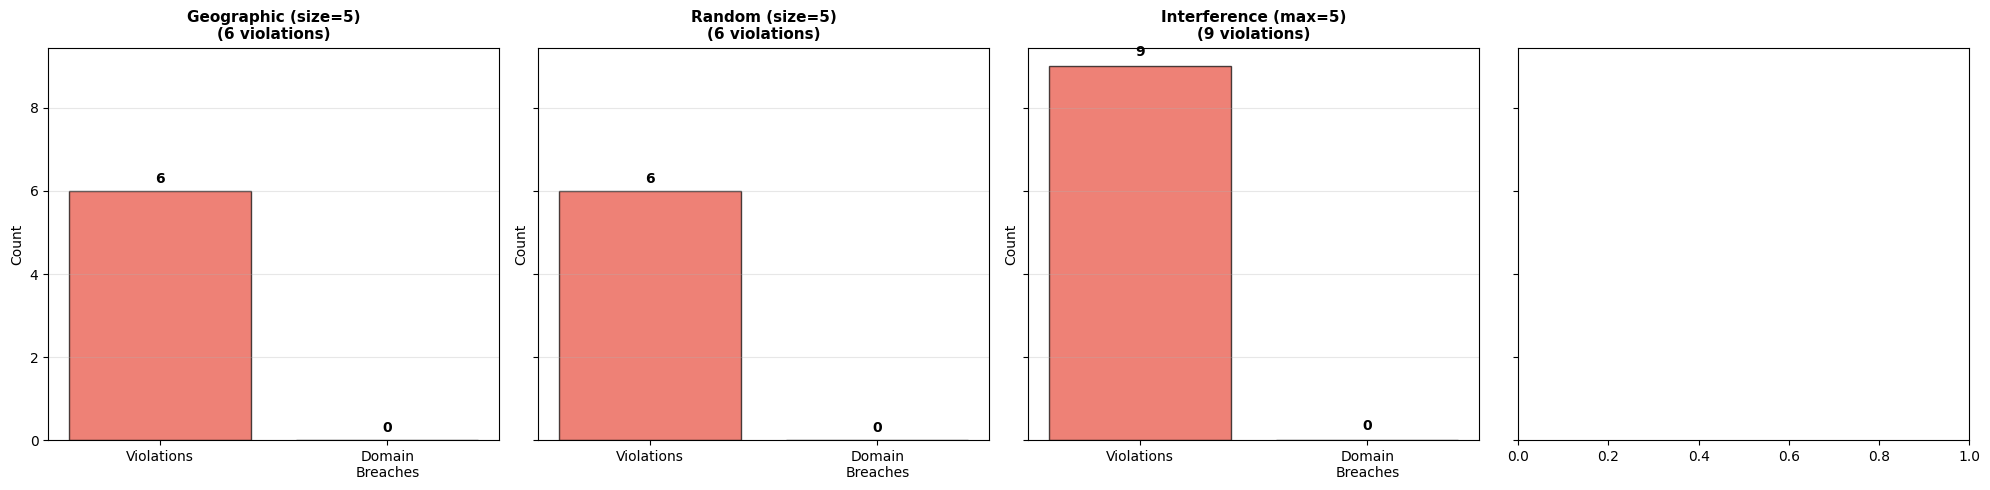


📊 Interpretation:
- Lower violations = better solution quality
- Multi-node blocks may converge faster but with different final quality
- Geographic blocks leverage spatial structure
- Random blocks provide mixing without spatial bias
- Interference blocks group conflicting stations for efficient resolution


In [35]:
%matplotlib inline

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

strategies = [
    # ("Single-Node", stats_single),
    (f"Geographic (size={BLOCK_SIZE_GEOGRAPHIC})", stats_geo),
    (f"Random (size={BLOCK_SIZE_RANDOM})", stats_random),
    (f"Interference (max={BLOCK_SIZE_INTERFERENCE})", stats_interference),
]

for ax, (name, stats) in zip(axes, strategies):
    violations = stats["violations"]
    domain_breaches = stats["domain_violations"]
    
    categories = ['Violations', 'Domain\nBreaches']
    values = [violations, domain_breaches]
    colors = ['#e74c3c' if v > 0 else '#27ae60' for v in values]
    
    ax.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_title(f"{name}\n({violations} violations)", fontsize=11, fontweight='bold')
    ax.set_ylabel('Count')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (cat, val) in enumerate(zip(categories, values)):
        ax.text(i, val + max(values) * 0.02, str(val), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("- Lower violations = better solution quality")
print("- Multi-node blocks may converge faster but with different final quality")
print("- Geographic blocks leverage spatial structure")
print("- Random blocks provide mixing without spatial bias")
print("- Interference blocks group conflicting stations for efficient resolution")